In [22]:
## Load Required Packages
library(readxl)
library(dplyr)
library(ggplot2)
library(glmnet)

## 1. Load and clean data
xlsx_path <- "C:\\Users\\User\\Desktop\\CausalAI-Course\\data\\Districtwise_literacy_rates.xlsx"
df <- read_excel(xlsx_path)
df_clean <- na.omit(df)

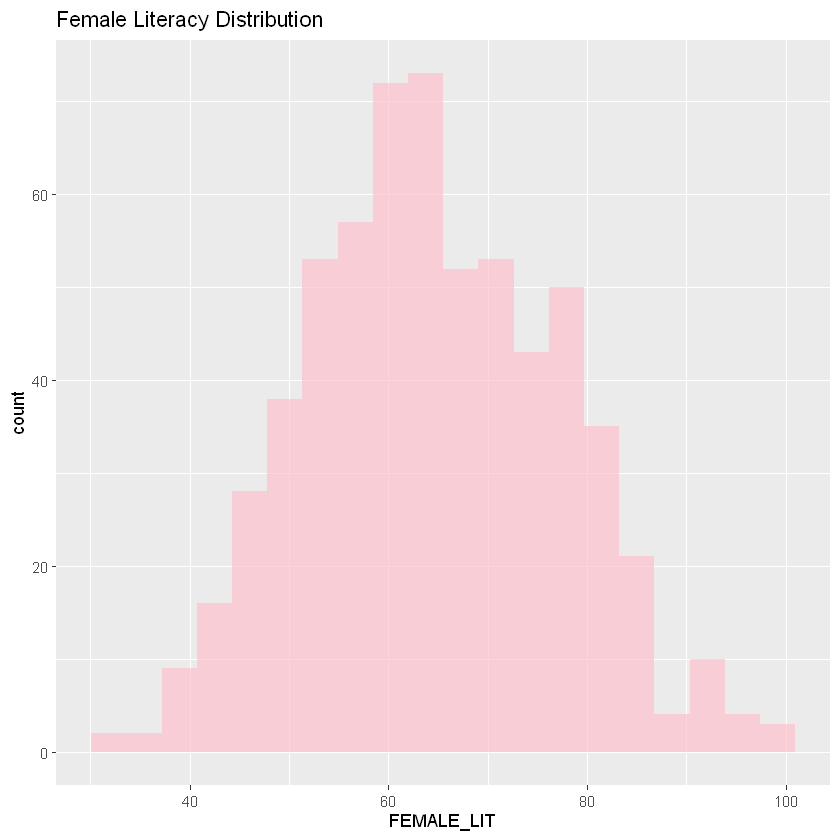

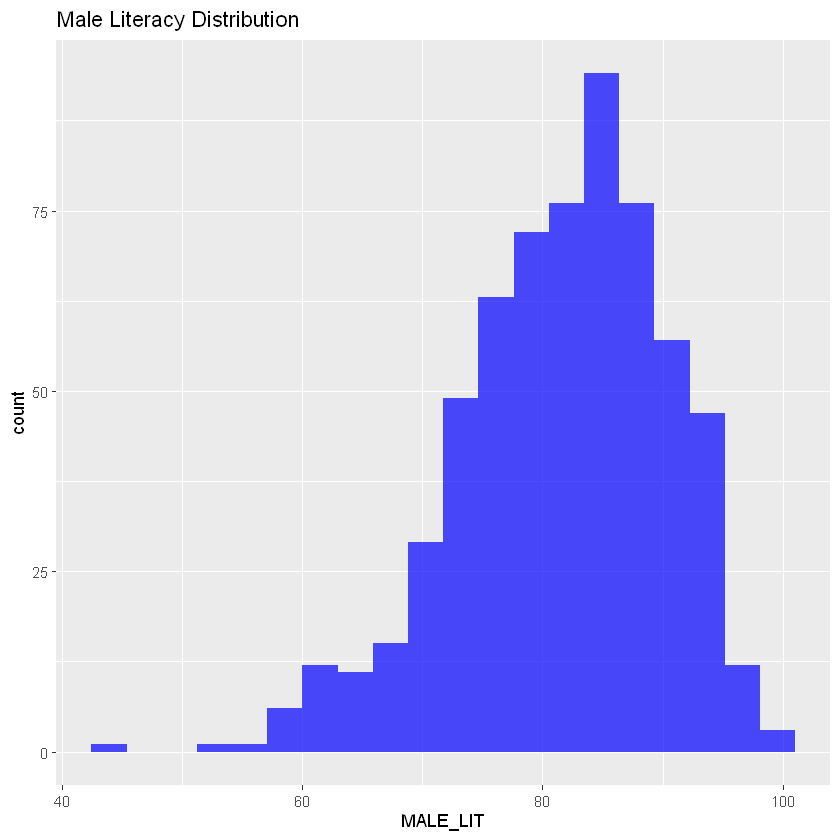

In [23]:
## 2. Histogram (1 point)
ggplot(df_clean, aes(x = FEMALE_LIT)) +
  geom_histogram(fill = "pink", bins = 20, alpha = 0.7) +
  labs(title = "Female Literacy Distribution")
ggplot(df_clean, aes(x = MALE_LIT)) +
  geom_histogram(fill = "blue", bins = 20, alpha = 0.7) +
  labs(title = "Male Literacy Distribution")



### Comentario sobre las distribuciones de alfabetización

- **Alfabetización femenina (FEMALE_LIT):**  
  La distribución se concentra principalmente entre **50% y 80%**, con un pico en torno a **60–65%**. Presenta mayor dispersión y existen distritos con niveles relativamente bajos.

- **Alfabetización masculina (MALE_LIT):**  
  La distribución está desplazada hacia la derecha, concentrándose entre **70% y 90%**. La mayoría de los distritos muestran niveles altos y la dispersión es menor en comparación con las mujeres.

- **Conclusión:**  
  Se observa una **brecha sistemática de género**: la alfabetización masculina tiende a ser **mayor y más homogénea** que la femenina.


In [26]:
## 3. Low-dimensional spec (2 points)
set.seed(123)
n <- nrow(df_clean)
train_idx <- sample(1:n, size = 0.7 * n)
train <- df_clean[train_idx, ]
test  <- df_clean[-train_idx, ]

lm_low <- lm(FEMALE_LIT ~ TOTPOPULAT + P_URB_POP + SEXRATIO, data = train)
pred_low <- predict(lm_low, newdata = test)
y_test <- test$FEMALE_LIT
R2_low <- 1 - sum((y_test - pred_low)^2) / sum((y_test - mean(y_test))^2)
R2_low

[1] 0.211076

In [27]:
## 4. High-dimensional spec (2 points)
flex_formula <- FEMALE_LIT ~ (TOTPOPULAT + P_URB_POP + SEXRATIO + AREA_SQKM + GROWTHRATE)^2 +
                 I(TOTPOPULAT^2) + I(P_URB_POP^2) + I(SEXRATIO^2) + I(AREA_SQKM^2) + I(GROWTHRATE^2)
lm_flex <- lm(flex_formula, data = train)
pred_flex <- predict(lm_flex, newdata = test)
R2_flex <- 1 - sum((y_test - pred_flex)^2) / sum((y_test - mean(y_test))^2)
R2_flex

[1] 0.33569

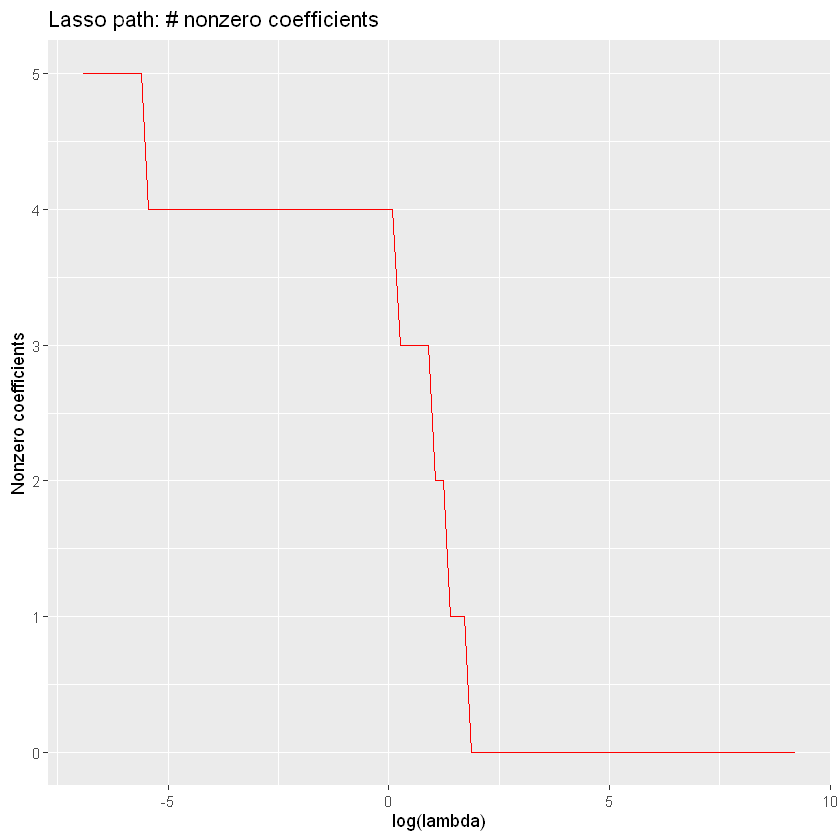

In [28]:
## 5. Lasso path (2.75 points)
X <- model.matrix(FEMALE_LIT ~ TOTPOPULAT + P_URB_POP + SEXRATIO + AREA_SQKM + GROWTHRATE, data = df_clean)[,-1]
y <- df_clean$FEMALE_LIT
lambda_seq <- exp(seq(log(10000), log(0.001), length.out = 100))
lasso_fit <- glmnet(X, y, alpha = 1, lambda = lambda_seq, standardize = TRUE)
nnz <- colSums(lasso_fit$beta != 0)

df_path <- data.frame(lambda = lambda_seq, nonzero = nnz)
ggplot(df_path, aes(x = log(lambda), y = nonzero)) +
  geom_line(color = "red") +
  labs(title = "Lasso path: # nonzero coefficients", x = "log(lambda)", y = "Nonzero coefficients")

# Comentario: con λ grande → casi todos coeficientes en cero; al reducir λ → entran más variables, 
# hasta que la mayoría son distintos de cero, mostrando selección de variables del Lasso.

### Comentario sobre el camino del Lasso

- **Valores grandes de λ (penalización alta):**  
  Todos los coeficientes se reducen a **cero**, lo que implica que el modelo no utiliza ninguna variable explicativa.

- **Valores intermedios de λ:**  
  A medida que la penalización disminuye, **aparecen gradualmente más coeficientes distintos de cero**. El número de variables seleccionadas crece de forma escalonada.

- **Valores pequeños de λ (penalización baja):**  
  El modelo mantiene hasta **5 predictores activos**, reflejando una mayor flexibilidad pero también un mayor riesgo de sobreajuste.

- **Conclusión:**  
  El gráfico ilustra la **propiedad de selección de variables del Lasso**: con penalización fuerte se eliminan variables irrelevantes, y con penalización débil se incluyen más predictores.
